In [1]:
import segmentation_models as sm
import tensorflow as tf
from pycocotools.coco import COCO
from pathlib import Path
import numpy as np
from typing import Final
from matplotlib import pyplot as plt
import cv2


Segmentation Models: using `tf.keras` framework.


In [2]:
image_size:Final[int] = 256

In [3]:
annotation_file = Path("annotations/instances_default.json")
coco = COCO(str(annotation_file))

for i in coco.getCatIds():
    if coco.loadCats(i)[0]["name"] == "Crack":
        cat_id = coco.loadCats(i)[0]["id"]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [5]:
def create_mask(anns, cat_id):
    mask = np.zeros((image_size, image_size, 1))
    for i in range(len(anns)):
        if anns[i]["category_id"] == cat_id:
            cv2.fillPoly(mask, pts=[np.array(anns[i]["segmentation"], dtype=np.int32).reshape(-1,1, 2)], color=(255,255,255))
    return mask

In [6]:
def read_data(idx, cat_id):
    anns = coco.loadAnns(coco.getAnnIds(idx))
    mask = create_mask(anns, cat_id)
    image = tf.keras.preprocessing.image.load_img(str(Path("./images") / coco.loadImgs(idx)[0]["file_name"]))
    return image, mask

result = [read_data(idx, cat_id) for idx in coco.getImgIds()]
images = np.concatenate([np.expand_dims(i, axis=0) for i, _ in result]) / 255
labels = np.concatenate([np.expand_dims(i, axis=0) for _, i in result]) / 255

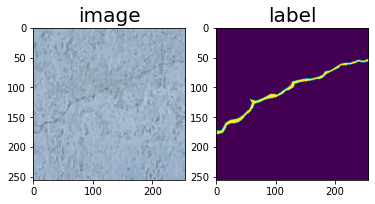

In [7]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("image",fontsize=20)
plt.imshow(images[0])
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("label",fontsize=20)
plt.imshow(labels[0])

In [8]:
train_ds = tf.data.Dataset.from_tensor_slices((images[:15,:,:,:], labels[:15,:,:,:])).batch(4)
test_ds = tf.data.Dataset.from_tensor_slices((images[15:,:,:,:], labels[15:,:,:,:])).batch(5)

In [17]:
model = sm.Unet(input_shape=(256, 256, 3))

In [18]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30)

model.compile(optimizer="adam", loss="mse",metrics=["mse"],)
model.fit(train_ds, epochs=300, validation_data=test_ds, batch_size=4, callbacks=[callback])

Epoch 1/300
4/4 [==============================] - 15s 3s/step - loss: 0.1747 - mse: 0.1747 - val_loss: 0.9101 - val_mse: 0.9101
Epoch 2/300
4/4 [==============================] - 11s 3s/step - loss: 0.1289 - mse: 0.1289 - val_loss: 0.9101 - val_mse: 0.9101
Epoch 3/300
4/4 [==============================] - 12s 3s/step - loss: 0.1035 - mse: 0.1035 - val_loss: 0.9100 - val_mse: 0.9100
Epoch 4/300
4/4 [==============================] - 12s 3s/step - loss: 0.0888 - mse: 0.0888 - val_loss: 0.9096 - val_mse: 0.9096
Epoch 5/300
4/4 [==============================] - 10s 3s/step - loss: 0.0800 - mse: 0.0800 - val_loss: 0.9099 - val_mse: 0.9099
Epoch 6/300
4/4 [==============================] - 12s 3s/step - loss: 0.0754 - mse: 0.0754 - val_loss: 0.9094 - val_mse: 0.9094
Epoch 7/300
4/4 [==============================] - 11s 3s/step - loss: 0.0719 - mse: 0.0719 - val_loss: 0.8743 - val_mse: 0.8743
Epoch 8/300
4/4 [==============================] - 12s 3s/step - loss: 0.0683 - mse: 0.0683 - val

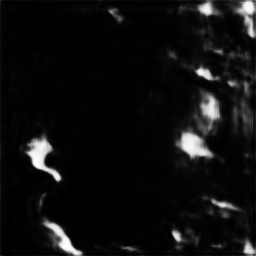

In [19]:
a = test_ds.unbatch()
image, label = list(a.take(1))[0]

tf.keras.preprocessing.image.array_to_img(model(tf.expand_dims(image, axis=0))[0])

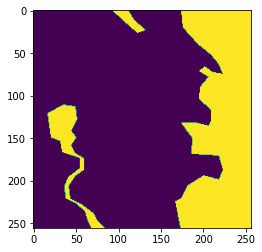

In [20]:
plt.imshow(label)